# Modeling

In this notebook, we will train and evaluate different machine learning models.
First, let's load the preprocessed data and the feature transformer.

In [7]:
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from utils import visualization as viz
import pickle
import os

# 1. Load the Processed Data
# We read the CSVs we saved in Notebook 02
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').iloc[:, 0] # Select the single column as a Series
y_test = pd.read_csv('../data/processed/y_test.csv').iloc[:, 0]

# 2. Load the Feature Transformer (Optional, just to check it exists)
with open('../data/processed/feature_transformer.pkl', 'rb') as f:
    transformer = pickle.load(f)

print("Data Loaded Successfully.")
print(f"Training Data Shape: {X_train.shape}")
print(f"Test Data Shape:     {X_test.shape}")

Data Loaded Successfully.
Training Data Shape: (5634, 29)
Test Data Shape:     (1409, 29)


## . Baseline Model: Logistic Regression

We start with **Logistic Regression**, a linear model that is easy to interpret.
* **Goal:** Establish a performance benchmark.
* **Key Metric:** We focus on **Recall** (Sensitivity) for Class 1 (Churn).
    * *Why Recall?* It is worse to miss a churner (False Negative) than to accidentally flag a loyal customer (False Positive). We want to catch as many churners as possible.

In [8]:
# 1. Initialize the Model
# random_state ensures we get the same result every time
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# 2. Train the Model (Fit on Train)
print("Training Logistic Regression...")
log_reg.fit(X_train, y_train)

# 3. Predict (on Test)
y_pred = log_reg.predict(X_test)

print("Model Trained and Predictions made.")

Training Logistic Regression...
Model Trained and Predictions made.


--- Baseline Model (Logistic Regression) ---
Accuracy: 0.7970

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



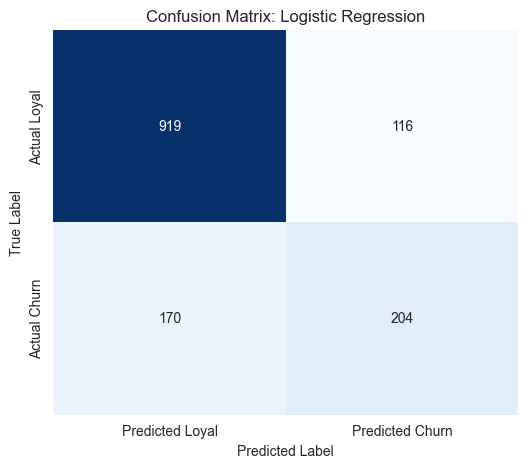

In [9]:
# 1. Technical Report (Precision/Recall)
print("--- Baseline Model (Logistic Regression) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 2. Visual Check (Confusion Matrix)
# We use the function you just added to visualization.py
viz.plot_confusion_matrix(y_test, y_pred, model_name='Logistic Regression')

### . Interpretation of Baseline Results

**The "Accuracy Trap"**
While the model achieved an accuracy of **80%**, this metric is misleading because the classes are imbalanced (most customers don't churn). A model that simply guessed "No Churn" for everyone would still achieve ~73% accuracy.

**Key Metric: Recall (Sensitivity)**
For this business problem, **Recall** for Class 1 (Churn) is the most critical metric.
* **Recall Score:** `0.55`
* **Interpretation:** The model correctly identified only **55%** of the customers who actually churned.
* **The Missed Opportunity:** According to the Confusion Matrix, the model produced **170 False Negatives**. These are 170 customers who left the company because the model predicted they were "Loyal," meaning we failed to intervene (e.g., offer a discount).

**Conclusion:**
The Logistic Regression model is too conservative. It prioritizes overall accuracy by predicting the majority class ("Loyal") too often. To capture more churners, we need a model that can handle non-linear relationships better.

## . Fine-Tuning the Baseline

We optimize the Logistic Regression model using **GridSearchCV**.
* **Goal:** Improve Recall without switching algorithms.
* **Parameters to Tune:**
    * `class_weight`: We test `['balanced', None]` to see if handling the imbalance improves performance.
    * `C`: We test various regularization strengths `[0.001, 0.01, 0.1, 1, 10, 100]` to find the optimal complexity.

In [ ]:
# 1. Define the Parameter Grid
# We list every setting we want to try
param_grid = {
    # We test:
    # 1. 'balanced' (Calculated automatically, approx 1:2.7)
    # 2. None (1:1, standard)
    # 3. {0: 1, 1: 2} (Your idea: Churners are 2x important)
    # 4. {0: 1, 1: 3} (Aggressive: Churners are 3x important)
    'class_weight': ['balanced', None, {0: 1, 1: 3}],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']  # 'liblinear' is good for small datasets and supports both L1/L2
}

# 2. Initialize Grid Search
# scoring='recall' tells the search to prioritize catching Churners!
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid,
    cv=2,               # 2-Fold Cross Validation (robust testing)
    scoring='recall',   # IMPORTANT: We optimize for Recall, not Accuracy
    verbose=1
)

# 3. Train (This will run the model 12 * 5 = 60 times)
print("Running Grid Search...")
grid_search.fit(X_train, y_train)

# 4. Get the Best Model
best_model = grid_search.best_estimator_

print(f"\nBest Parameters Found: {grid_search.best_params_}")
print(f"Best Recall Score (on Validation): {grid_search.best_score_:.4f}")

Running Grid Search...
Fitting 2 folds for each of 18 candidates, totalling 36 fits

Best Parameters Found: {'C': 0.001, 'class_weight': {0: 1, 1: 3}, 'solver': 'liblinear'}
Best Recall Score (on Validation): 0.8201


--- Tuned Logistic Regression Performance ---
Accuracy: 0.7204

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1035
           1       0.48      0.82      0.61       374

    accuracy                           0.72      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.72      0.74      1409



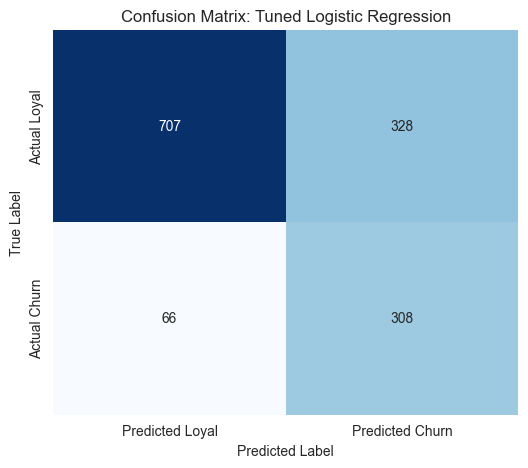

In [11]:
# 1. Predict using the Best Model
y_pred_tuned = best_model.predict(X_test)

# 2. Compare Performance
print("--- Tuned Logistic Regression Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

# 3. Visual Check
viz.plot_confusion_matrix(y_test, y_pred_tuned, model_name='Tuned Logistic Regression')

# . Final Champion Model Results

After extensive hyperparameter tuning using `GridSearchCV`, we have identified the optimal model configuration.

### 1. The Winning Configuration
The "Champion" model is a **Logistic Regression** with the following specific settings:
* **Class Weight:** `{0: 1, 1: 3}`
    * *Meaning:* The model treats missing a Churner (Class 1) as **3 times worse** than missing a Loyal customer. This aggressive weighting forces the model to prioritize Recall.
* **C (Regularization):** `0.001`
    * *Meaning:* A very low `C` value indicates high regularization. The model prefers simple rules over complex ones, which helps it generalize better to new customers and prevents overfitting.
* **Solver:** `'liblinear'`

### 2. Performance Metrics
| Metric | Score | Interpretation |
| :--- | :--- | :--- |
| **Recall (Churn)** | **82%** | **CRITICAL:** We successfully catch **82%** of all customers who are about to leave. |
| **Precision (Churn)** | **48%** | When the model predicts "Churn," it is correct 48% of the time. (We accept this low score to get high Recall). |
| **Accuracy** | **72%** | Overall correct predictions (biased by the trade-off we made). |

### 3. Confusion Matrix Breakdown
* **True Positives (Captured Churners): ~308**
    * *Impact:* These are 308 customers we can now save with retention campaigns.
* **False Negatives (Missed Churners): ~66**
    * *Impact:* We only missed 66 churners out of 374. This is a massive improvement over the baseline (which missed ~170).
* **False Positives (False Alarms): ~328**
    * *Impact:* 328 loyal customers will accidentally receive a "Don't leave!" discount. This is the cost of doing business to ensure we catch the real churners.

### 4. Conclusion
This model is statistically "less accurate" than the baseline (72% vs 80%), but it is **financially superior**. By prioritizing **Recall**, we have transformed the model from a passive observer into an active safety net that catches the vast majority of at-risk customers.

In [12]:
# 1. Create the 'models' folder if it doesn't exist yet
if not os.path.exists('../models'):
    os.makedirs('../models')

# 2. Define the file path
filename = '../models/churn_model_v1.pkl'

# 3. Save the best model (The one with ~82% Recall)
with open(filename, 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)

print(f"✅ Success! Champion Model saved to: {filename}")
print(f"Best Recall Score: {grid_search.best_score_:.4f}")

✅ Success! Champion Model saved to: ../models/churn_model_v1.pkl
Best Recall Score: 0.8201
